In [724]:
%matplotlib inline

In [725]:
import numpy as np
import scipy.integrate
import scipy.optimize
from matplotlib import pyplot as plt

# Fitting $\mu$

In [726]:
Cx_avg = [1.1255664, 1.267432267, 1.469832267, 1.6822116, 1.9686732]
Cx_A2 = [0.8711072, 0.9804736, 1.390476, 1.5821988, 1.963604]
Cx_B2 = [1.072592, 1.2538232, 1.4700208, 1.800436, 2.1084156]
Cx_C2 = [1.433, 1.568, 1.549, 1.664, 1.834]
tspan = [1.5, 2.5, 3.5, 4.5, 5.5]

In [727]:
Cx_avg = (np.array(Cx_A2) + np.array(Cx_B2)) / 2
Cx_avg

array([0.9718496, 1.1171484, 1.4302484, 1.6913174, 2.0360098])

In [728]:
tvals = np.array(tspan)

In [729]:
def fit(t, k, mu):
    Cx = k*scipy.e**(mu*t)
    return Cx

In [730]:
parameters_avg = scipy.optimize.curve_fit(fit, tspan, Cx_avg, p0=[0.5, 0.5])[0]
k_avg, μ_avg = parameters_avg[0], parameters_avg[1]
k_avg, μ_avg

(0.721732693531793, 0.18907695326370638)

In [731]:
Cx_avg_pred = fit(tvals, k_avg, μ_avg)

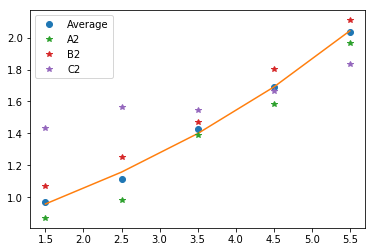

In [732]:
plt.plot(tspan, Cx_avg, 'o', label='Average')
plt.plot(tvals, Cx_avg_pred)
plt.plot(tvals, Cx_A2, '*', label='A2')
plt.plot(tvals, Cx_B2, '*', label='B2')
plt.plot(tvals, Cx_C2, '*', label='C2')
plt.legend(loc='best')

In [733]:
parameters_A2 = scipy.optimize.curve_fit(fit, tspan, Cx_A2, p0=[0.5, 0.5])[0]
k_A2, μ_A2 = parameters_A2
k_A2, μ_A2

(0.6290670260099501, 0.2076521286067348)

In [734]:
Cx_A2_pred = fit(tvals, k_A2, μ_A2)

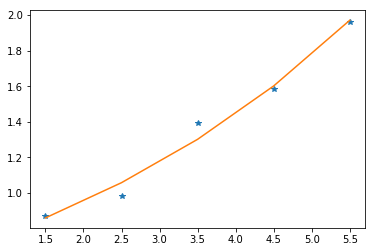

In [735]:
plt.plot(tspan, Cx_A2, '*')
plt.plot(tvals, Cx_A2_pred)

# Flux Model

In [736]:
α = 0.1
β = 0.1
θ = 0.05

In [771]:
γ = 0.4

In [772]:
μ = μ_avg

In [773]:
def response_function(C):
    Cx, Cs, Ce = C
    #                0       1    2      3    4
    A = np.matrix([ [-1, (1+α),    1,    0,   0], # Node C
                    [0,      0,   -1,    1, 1.5], # Node C
                    [0,      β,    0, -1/3,   0], # NADH Balance
                    [0,     -γ, -1/3,    0,   1], # ATP Balance
                    [0,      1,    0,    0,   0], # Basis r1 = rX = μ            
                                                     ])

    b = np.matrix([0, 0, 0, θ, μ]).T
    r = np.linalg.solve(A, b)
    
    return [ r[1,0], # rX - Biomass
            -r[0,0], # -rS - Glucose is consumed
             r[4,0]] # r

In [774]:
def fermenter_equation(C, t):
    Cx, Cs, Ce = C
    rx, rs, re = response_function(C)
    dCxdt = rx*Cx
    dCsdt = rs*Cx
    dCedt = re*Cx
    return [dCxdt, dCsdt, dCedt]

In [775]:
t1 = np.linspace(0, 3, 500)

In [776]:
MM_X = 24.6 #gX/cmolX
MM_S = 30   #gS/cmolS

In [777]:
Cxo = k_avg/MM_X  #cmolX/L

In [778]:
Cso_1 = (25/0.5)/MM_S
Gluc_addition = (5/0.5)/MM_S

In [779]:
Co_1 = [Cxo, Cso_1, 0]

In [780]:
Ci_1 = scipy.integrate.odeint(fermenter_equation, Co_1, t1)
ri = np.asarray([response_function(C) for C in Ci_1])

In [781]:
Cx_1, Cs_1, Ce_1 = Ci_1.T
rx, rs, re = ri.T   # rates are constant throughout due to lack of inhibition

In [782]:
Cxo_2 = Cx_1[-1] 
Cso_2 = Cs_1[-1] + Gluc_addition
Ceo_2 = Ce_1[-1]
Co_2 = [Cxo_2, Cso_2, Ceo_2]

In [783]:
t2 = np.linspace(3, 4, 500)

In [784]:
Ci_2 = scipy.integrate.odeint(fermenter_equation, Co_2, t2)

In [785]:
Cx_2, Cs_2, Ce_2 = Ci_2.T

In [786]:
Cxo_3 = Cx_2[-1] 
Cso_3 = Cs_2[-1] + Gluc_addition
Ceo_3 = Ce_2[-1]
Co_3 = [Cxo_3, Cso_3, Ceo_3]

In [787]:
t3 = np.linspace(4, 6, 500)

In [788]:
Ci_3 = scipy.integrate.odeint(fermenter_equation, Co_3, t3)

In [789]:
Cx_3, Cs_3, Ce_3 = Ci_3.T

In [790]:
Cs_tot = np.concatenate((Cs_1, Cs_2, Cs_3))  # merges all three arrays together

In [791]:
t_tot = np.concatenate((t1, t2, t3))

Text(0.5, 0, 't (h)')

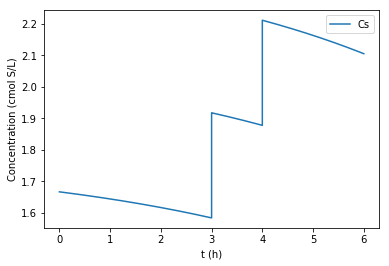

In [792]:
plt.plot(t_tot, Cs_tot)
plt.legend(['Cs'])
plt.ylabel('Concentration (cmol S/L)')
plt.xlabel('t (h)')

In [793]:
Cx_tot = np.concatenate((Cx_1, Cx_2, Cx_3))  # merges all three arrays together
Ce_tot = np.concatenate((Ce_1, Ce_2, Ce_3))  # merges all three arrays together

Text(0, 0.5, 'Concentration (cmol/L)')

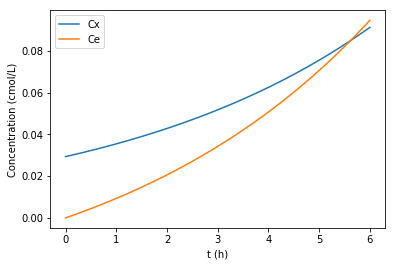

In [794]:
plt.plot(t_tot, Cx_tot)
plt.plot(t_tot, Ce_tot)
plt.legend(['Cx', 'Ce'], loc = 'best')
plt.xlabel('t (h)')
plt.ylabel('Concentration (cmol/L)')

Text(0, 0.5, 'Concentration of biomass (g/L)')

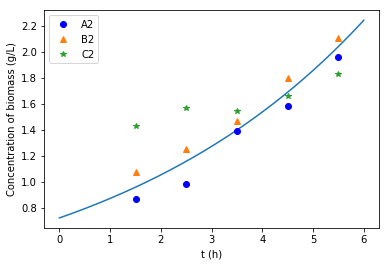

In [795]:
Cx_tot_mass = Cx_tot * MM_X # g/L
plt.plot(t_tot, Cx_tot_mass)
plt.plot(tvals, Cx_A2, 'ob', label='A2')
plt.plot(tvals, Cx_B2, '^', label='B2')
plt.plot(tvals, Cx_C2, '*', label='C2')
plt.legend(loc='best')
plt.xlabel('t (h)')
plt.ylabel('Concentration of biomass (g/L)')

In [796]:
T = 23 + 273.15 #K
P = 86 #kPa
R = 8.314 # kPa.L/mol.K

In [797]:
rCO2 = (α*rx + 0.5*re) #(mol CO2)/(cmol X.h)
rCO2_tot = np.concatenate((rCO2, rCO2, rCO2))
rCO2_mL_min = rCO2_tot * (1/60) * Cx_tot * ((R*T)/P) * 1000 # mL/min

In [798]:
t_CO2 = [1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25]
rCO2_A2 = [1.958, 2.192, 2.667, 3.6, 4.143, 4.625, 5.714, 7.667, 7.82]
rCO2_B2 = [2.666, 3.0833, 3.5341, 4.25, 4.875, 5.6238, 6.6667, 7.4083, 8.3333]
rCO2_C2 = [1.89, 2.34, 3.073, 4.12, 4.718, 5.035, 5.652, 7.256, 7.7]
rCO2_avg = [2.171333333, 2.538433333, 3.091366667, 3.99, 4.578666667, 5.0946, 6.0109, 7.443766667, 7.9511]

Text(0, 0.5, 'rCO2 (mL/min)')

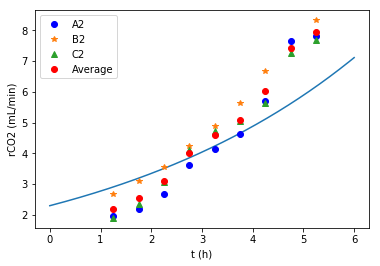

In [799]:
plt.plot(t_tot, rCO2_mL_min)
plt.plot(t_CO2, rCO2_A2, 'ob',label='A2')
plt.plot(t_CO2, rCO2_B2, '*',label='B2')
plt.plot(t_CO2, rCO2_C2, '^',label='C2')
plt.plot(t_CO2, rCO2_avg, 'or', label='Average')
plt.legend(loc='best')
plt.xlabel('t (h)')
plt.ylabel('rCO2 (mL/min)')
# plt.axis([0,6,0,10])

In [800]:
def ferm_eq_2(t,C):
    Cx, Ce, Cs = C 
    r=response_fun_2(C)
    
    return [r[0]*Cx,
            r[1]*Cx,
            r[2]*Cx]   

In [803]:
error=1000

for gamma in np.arange(0, 2, 0.01):
    squares = 0
    
    def response_fun_2(C):
        Cx, Ce, Cs = C

        S = np.matrix([[-1,1+α,1,0,0],
                          [ 0,0,-1,1,1.5],
                          [  0,β,0,-1/3,0],
                          [ 0,-gamma,-1/3,0,1],
                          [ 0,1,0,0,0]])

        sol = np.matrix([0, 0, 0, θ, μ_avg]).T
        r = np.linalg.solve(S, sol) 

        return [μ_avg,        # biomass
                r[4,0],    # ethanol  
                -r[0,0]]   # glucose
    
    Co = [Cxo, 0, (25*2)/30]
    tspan = [0,6]   
#     print (Co)
    t2 = [1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25] 
    C = scipy.integrate.solve_ivp(ferm_eq_2, tspan, Co, t_eval = t2).y
#     print (C)
    
    fitted_rco2_list=[]
    
    for index, value in enumerate(rCO2_avg):
#         print ((C[0][index], C[1][index], C[2][index]))
        rates = response_fun_2((C[0][index], C[1][index], C[2][index]))
        rx, re, rs = rates
        tmax = 6
        Cx = Cx_tot
        cx = Cx[np.where(np.linspace(0,tmax,tmax*100+1) == t2[index])]
#         print (numpy.where(numpy.linspace(0,tmax,tmax*100+1) == t2[index]))
      
#         fitted_rco2 = (0.5*re+α*rx)*(1/60)*8.314*(T)*1000/P*(cx)/24.6*0.5
        fitted_rco2 = (0.5*re+α*rx) * (1/60) * (cx) * ((R*T)/P) * 1000
#         print (fitted_rco2, value, gamma)
        squares += (fitted_rco2 - value)**2
#         print (squares)
        fitted_rco2_list.append(fitted_rco2)
    
    if squares < error:
#         print (squares, gamma)
        gamma_acc = gamma
        error = squares
        fitted_rco2_acc = fitted_rco2_list
#     print (squares, gamma)

In [804]:
gamma_acc

0.81

In [805]:
γ = gamma_acc

In [806]:
print(fitted_rco2_acc)

[array([3.8884987]), array([4.11590967]), array([4.35662061]), array([4.61140903]), array([4.88109825]), array([5.16655974]), array([5.46871618]), array([5.78854328]), array([6.00525638])]


In [807]:
print(t2)

[1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25]


[0.18907695326370638, 0.18907695326370638, 0.18907695326370638, 0.18907695326370638, 0.18907695326370638, 0.18907695326370638, 0.18907695326370638, 0.18907695326370638, 0.18907695326370638] [0.44412005493994566, 0.44412005493994566, 0.44412005493994566, 0.44412005493994566, 0.44412005493994566, 0.44412005493994566, 0.44412005493994566, 0.44412005493994566, 0.44412005493994566]


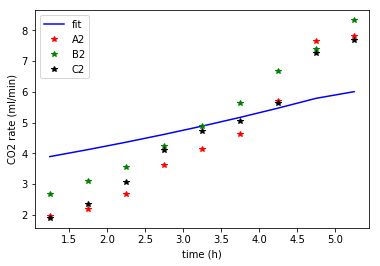

In [811]:
# Ci=(C[:, :1]) 
# print (Ci)
# r=asarray([response_fun(Ci) for C in C])       

r=[]
rx=[]
re=[]
for values in zip(C[0],C[1],C[2]):
    r.append(response_function(values))
    rx.append(response_function(values)[0])
    re.append(response_function(values)[2])
print (rx, re)

T, P = 23, 86  # °C, kPa 
 

plt.plot(t2, fitted_rco2_acc, color='blue', label='fit')
plt.plot(t2, rCO2_A2, '*', color='red',label='A2')
plt.plot(t2, rCO2_B2, '*', color='green',label='B2')
plt.plot(t2, rCO2_C2, '*', color='black',label='C2')

plt.legend(loc='best')
plt.ylabel('CO2 rate (ml/min)') 
plt.xlabel('time (h)') 
plt.show()